In [1]:
# libraries import

# EDA
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

#data wrangling
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# modelling
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

EDA

In [3]:
train = pd.read_csv('aug_train.csv')
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
train.shape

(19158, 14)

In [5]:
print("Missing values in the train dataset:\n\n",train.isna().sum())

Missing values in the train dataset:

 enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


Data wrangling

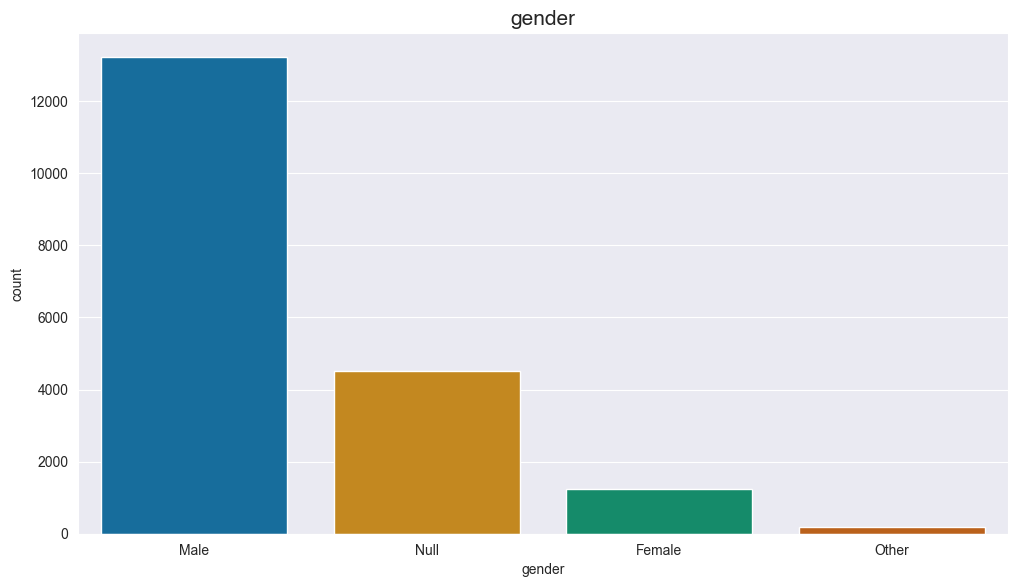

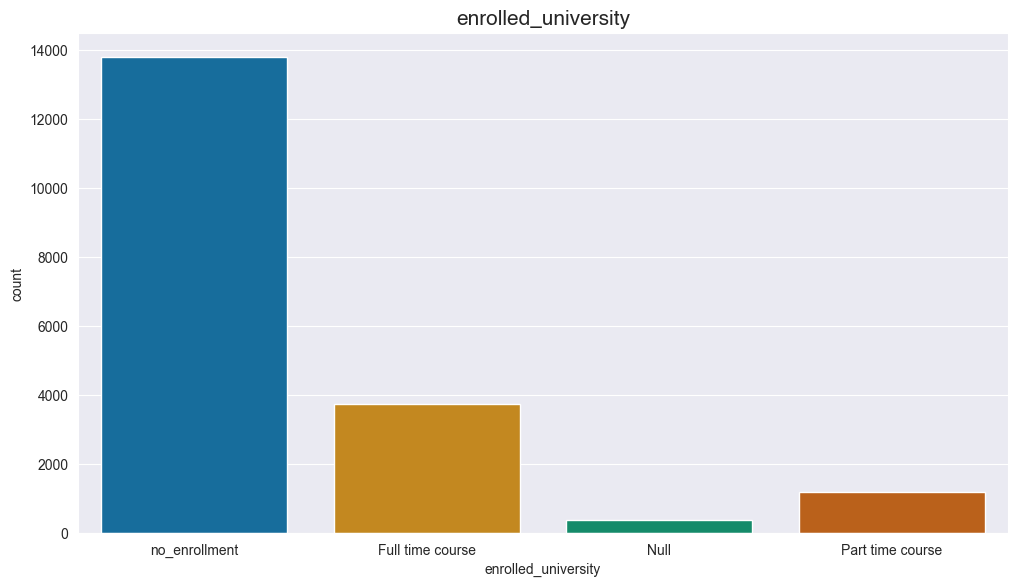

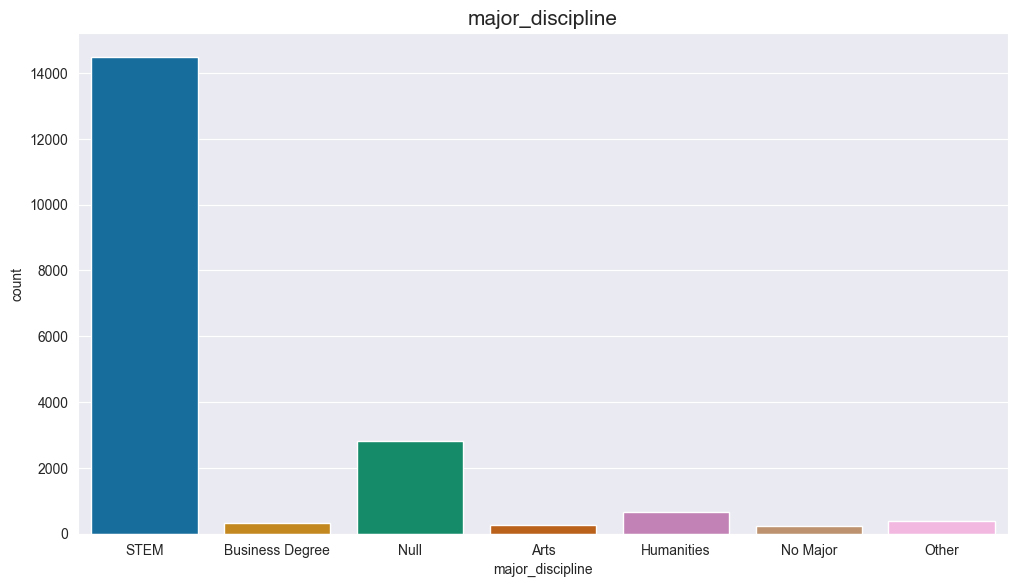

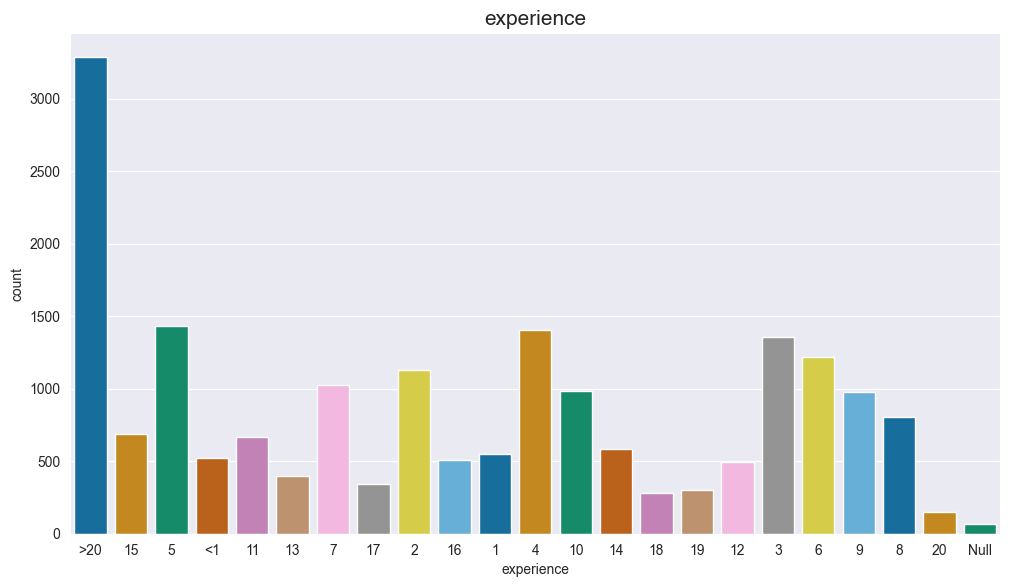

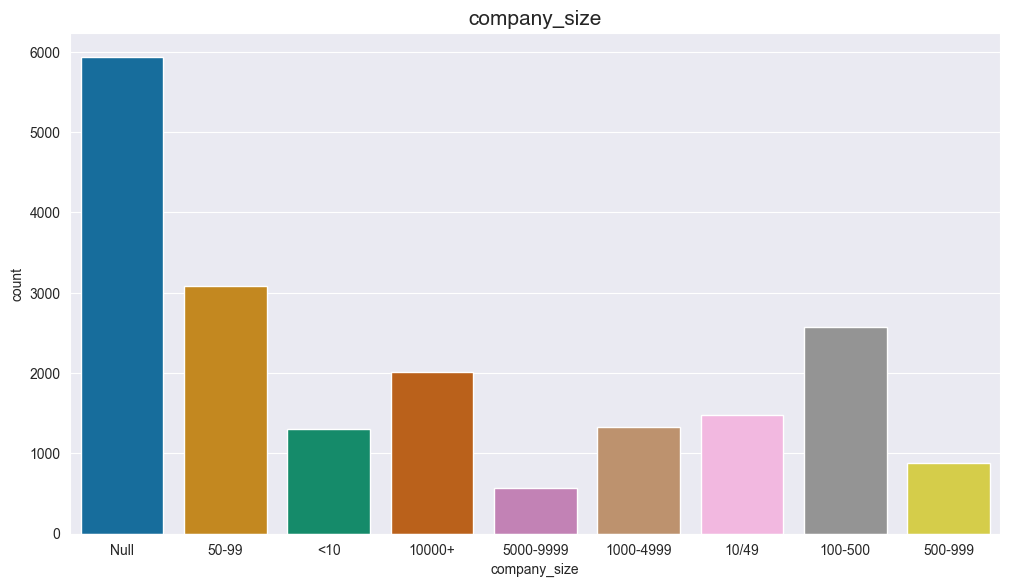

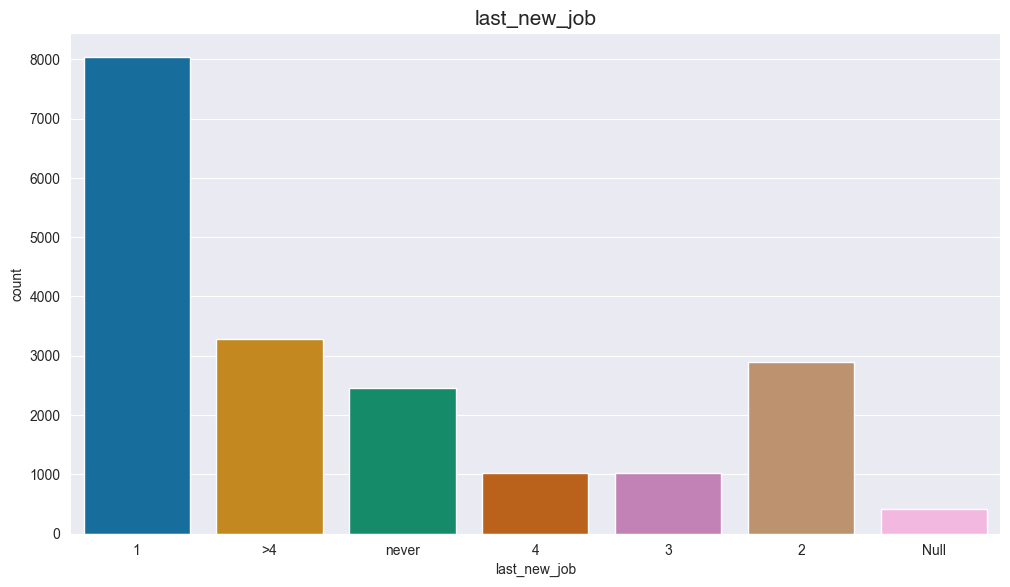

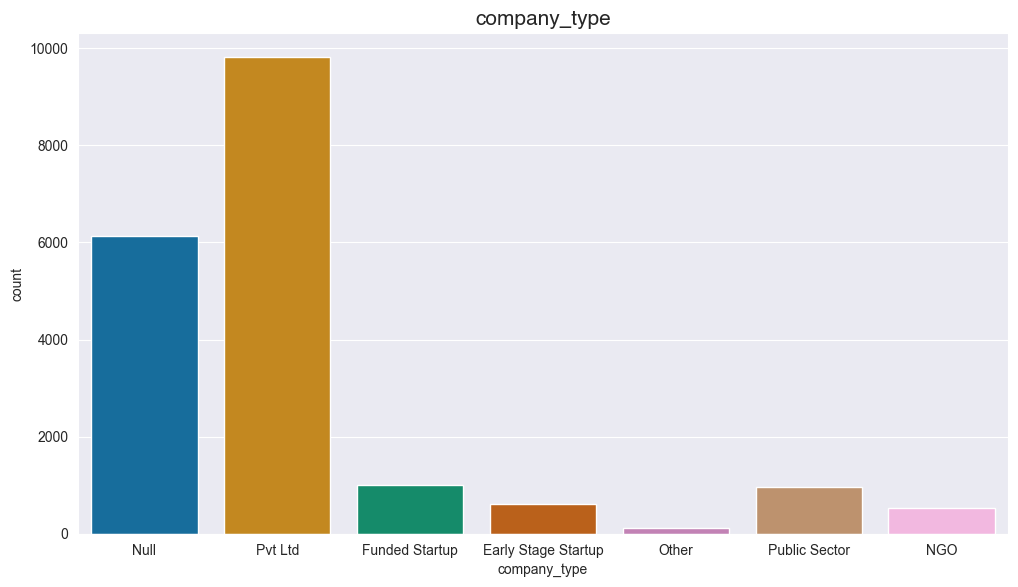

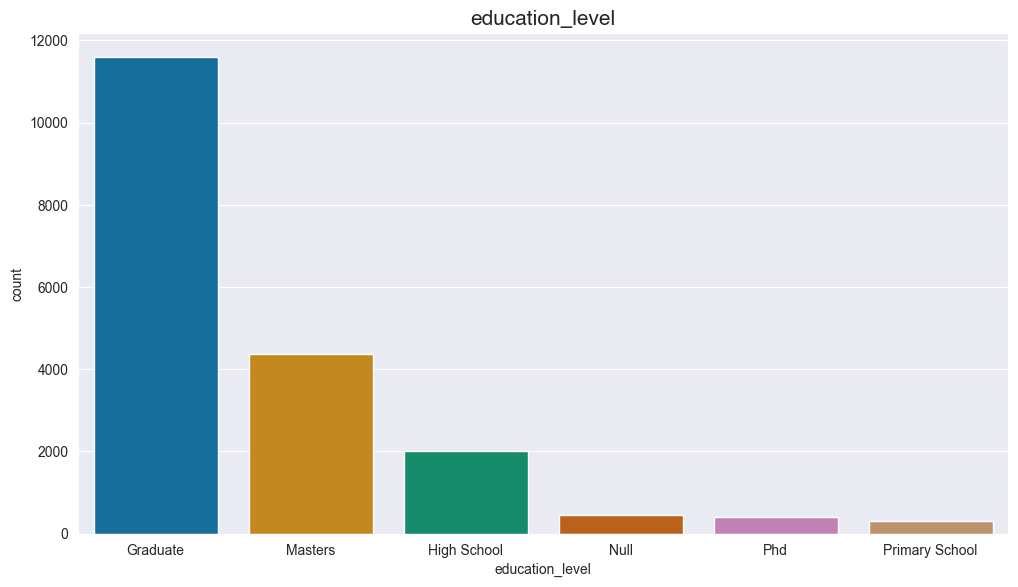

In [6]:
cols_with_nan_data = ['gender', 'enrolled_university', 'major_discipline', 'experience', 'company_size', 'last_new_job', 'company_type', 'education_level']
colorblind_palette = sns.color_palette("colorblind")

for i in cols_with_nan_data:
    plt.figure(figsize=(12,6.5))
    plt.title(i, fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
    sns.countplot(data=train.fillna('Null'), x=i, palette=colorblind_palette)
    plt.show()

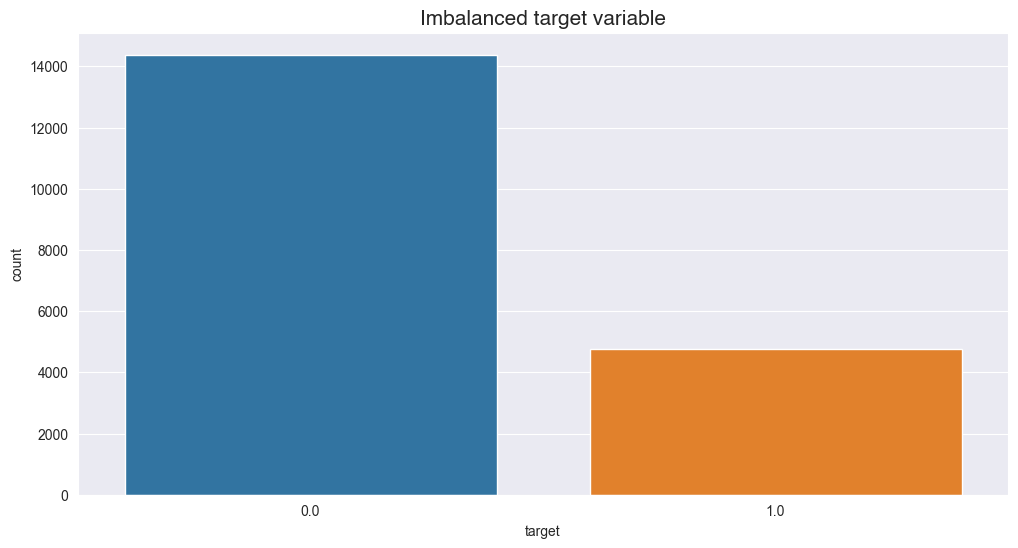

In [8]:
plt.figure(figsize=(12,6))
plt.title("Imbalanced target variable", fontsize=15, fontweight='bold', fontname='Helvetica', ha='center')
ax = sns.countplot(x='target', data=train)

In [9]:
train['target'].value_counts(1)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [10]:
# handling null values
train['city'] = train['city'].str.split("_",expand=True)[1].astype('int64')
train['gender'] = train['gender'].replace(np.nan, 'Male')
train['enrolled_university'] = train['enrolled_university'].replace(np.nan, 'no_enrollment')
train['education_level'] = train['education_level'].replace(np.nan,'Graduate')
train['major_discipline'] = train['major_discipline'].replace(np.nan,'STEM')
train['experience'] = train['experience'].replace(np.nan,'>20')
train['company_size'] = train['company_size'].replace(np.nan,'50-99')
train['company_type'] = train['company_type'].replace(np.nan,'Pvt Ltd')
train['last_new_job'] = train['last_new_job'].replace(np.nan,'1')
data = train[train['gender'] != 'Other']
data

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,36,1.0
1,29725,40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never,83,0.0
3,33241,115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,50-99,Pvt Ltd,never,52,1.0
4,666,162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,50-99,Pvt Ltd,1,42,1.0
19154,31398,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,4,52,1.0
19155,24576,103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,65,0.802,Male,Has relevent experience,no_enrollment,High School,STEM,<1,500-999,Pvt Ltd,2,97,0.0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18967 non-null  int64  
 1   city                    18967 non-null  int64  
 2   city_development_index  18967 non-null  float64
 3   gender                  18967 non-null  object 
 4   relevent_experience     18967 non-null  object 
 5   enrolled_university     18967 non-null  object 
 6   education_level         18967 non-null  object 
 7   major_discipline        18967 non-null  object 
 8   experience              18967 non-null  object 
 9   company_size            18967 non-null  object 
 10  company_type            18967 non-null  object 
 11  last_new_job            18967 non-null  object 
 12  training_hours          18967 non-null  int64  
 13  target                  18967 non-null  float64
dtypes: float64(2), int64(3), object(9)
mem

In [12]:
# encoding categorical data
pd.options.mode.chained_assignment = None
ordinal_atributes = ['education_level', 'experience', 'company_size', 'last_new_job']

cardinal_atributes = ['gender', 'relevent_experience', 'enrolled_university', 'major_discipline', 'company_type']

ordinal_pipeline = Pipeline([
    ('OrdinalEncoder',OrdinalEncoder(categories=[
                                    ['Unknown', 'Primary School',  'High School', 'Graduate', 'Masters', 'Phd'],
                                    'Unknown,<1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,>20'.split(','),
                                    ['Unknown','<10', '10/49', '50-99', '100-500', '500-999' ,'1000-4999', '5000-9999', '10000+'],
                                    ['Unknown','1', '2', '3', '4', '>4', 'never']
                                ]))
])

ordinal_pipeline.fit(data[ordinal_atributes])
data[ordinal_atributes] = ordinal_pipeline.transform(data[ordinal_atributes])
data = pd.get_dummies(data, columns=cardinal_atributes)
data.head()

,enrollee_id,city,city_development_index,education_level,experience,company_size,last_new_job,training_hours,target,gender_Female,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,company_type_Early Stage Startup,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd
0,8949,103,0.920,3.0,22.0,3.0,1.0,36,1.0,0,...,0,0,0,1,0,0,0,0,0,1
1,29725,40,0.776,3.0,16.0,3.0,5.0,47,0.0,0,...,0,0,0,1,0,0,0,0,0,1
2,11561,21,0.624,3.0,6.0,3.0,6.0,83,0.0,0,...,0,0,0,1,0,0,0,0,0,1
3,33241,115,0.789,3.0,1.0,3.0,6.0,52,1.0,0,...,0,0,0,0,0,0,0,0,0,1
4,666,162,0.767,4.0,22.0,3.0,4.0,8,0.0,0,...,0,0,0,1,0,1,0,0,0,0


In [13]:
# balancing target variable
columns = data.columns.tolist()
columns = [c for c in columns if c not in ['target']]
y = data['target']
X = data[columns]

ros = RandomOverSampler(sampling_strategy='minority')
X_balanced, y_balanced = ros.fit_resample(X, y)
print(f"Imbalanced target class: {Counter(y)}\n\nBalanced target class: {Counter(y_balanced)}\n")
print(X_balanced.shape[0] - data.shape[0], 'new random picked points')

Imbalanced target class: Counter({0.0: 14240, 1.0: 4727})

Balanced target class: Counter({1.0: 14240, 0.0: 14240})

9513 new random picked points


Modelling

In [14]:
X_ros,X_test,y_ros,y_test = train_test_split(X_balanced, y_balanced,test_size=0.3,random_state=1)
X_ros.shape,X_test.shape,y_ros.shape,y_test.shape

((19936, 27), (8544, 27), (19936,), (8544,))

In [15]:
#random forest

rfc = RandomForestClassifier(n_estimators = 50, class_weight = {0:1, 1:4})
rfc.fit(X_ros, y_ros)
y_pred_rfc = rfc.predict(X_test)

print(classification_report(y_test, y_pred_rfc))
print("Accuracy score of Random forest : {:.2f}".format(accuracy_score(y_pred_rfc,y_test)))
print("Recall score of Random forest : {:.2f}".format(recall_score(y_pred_rfc,y_test,average='macro',zero_division=True)))
print("Precision score of Random forest : {:.2f}".format(precision_score(y_pred_rfc,y_test,zero_division = True)))
print("F1 score of Random forest : {:.2f}".format(f1_score(y_pred_rfc,y_test,zero_division=True)))

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.88      4232
         1.0       0.85      0.93      0.89      4312

    accuracy                           0.88      8544
   macro avg       0.89      0.88      0.88      8544
weighted avg       0.89      0.88      0.88      8544

Accuracy score of Random forest : 0.88
Recall score of Random forest : 0.89
Precision score of Random forest : 0.93
F1 score of Random forest : 0.89


Fitting 3 folds for each of 54 candidates, totalling 162 fits
The accuracy score with using the tuned Random Forest is : 0.7225118559785146


/Users/katarzynahewelt/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


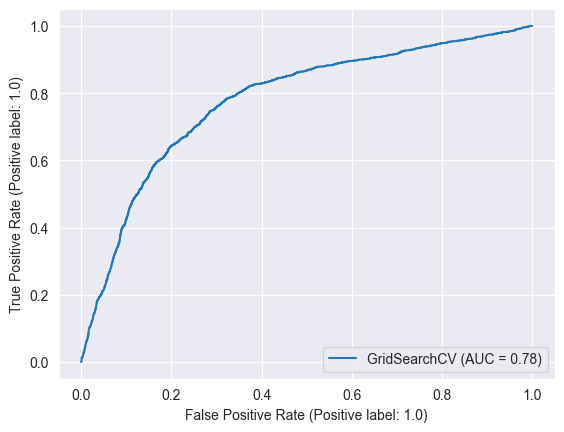

In [16]:
params = {'max_leaf_nodes': list(range(2, 20)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_ros, y_ros)

grid_search_cv.best_estimator_
grid_search_cv.best_params_
rf_accuracy = grid_search_cv.best_score_
print('The accuracy score with using the tuned Random Forest is :',rf_accuracy)
plot_roc_curve(grid_search_cv, X_test, y_test)

In [17]:
# xgboost
xgbc = XGBClassifier(use_label_encoder=False)
xgbc.fit(X_ros,y_ros)
y_pred_xgbc = xgbc.predict(X_test)
xgb_accuracy = accuracy_score(y_test,xgbc.predict(X_test))

print(classification_report(y_test, y_pred_xgbc))
print("Accuracy score of XGBclassifier : {:.2f}".format(accuracy_score(y_pred_xgbc,y_test)))
print("Recall score of XGBclassifier : {:.2f}".format(recall_score(y_pred_xgbc,y_test,average='macro',zero_division=True)))
print("Precision score of XGBclassifier : {:.2f}".format(precision_score(y_pred_xgbc,y_test,zero_division = True)))
print("F1 score of XGBclassifier : {:.2f}".format(f1_score(y_pred_xgbc,y_test,zero_division=True)))

/Users/katarzynahewelt/Library/Python/3.9/lib/python/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79      4232
         1.0       0.78      0.85      0.81      4312

    accuracy                           0.80      8544
   macro avg       0.80      0.80      0.80      8544
weighted avg       0.80      0.80      0.80      8544

Accuracy score of XGBclassifier : 0.80
Recall score of XGBclassifier : 0.80
Precision score of XGBclassifier : 0.85
F1 score of XGBclassifier : 0.81


In [18]:
# comparison

accuracies = {"Random Forest Accuracy":accuracy_score(y_pred_rfc,y_test), "XGB Accuracy":xgb_accuracy}
print("The best score has the model: ", max(accuracies, key=accuracies.get))

The best score has the model:  Random Forest Accuracy


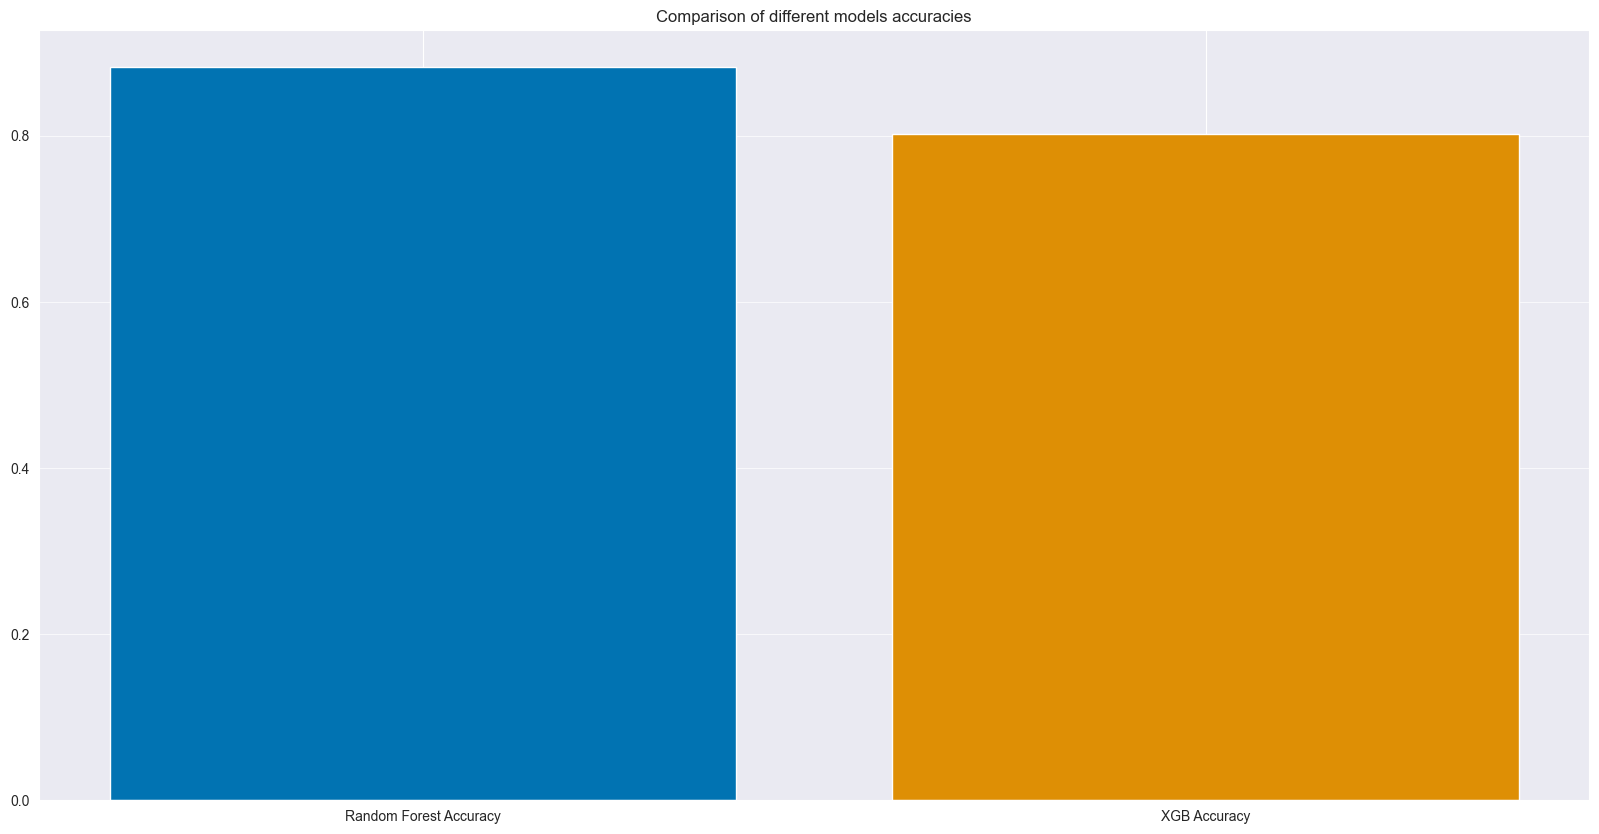

In [19]:
plt.figure(figsize=(20,10))
colorblind_palette = sns.color_palette('colorblind')
plt.bar(*zip(*accuracies.items()), color=colorblind_palette, width = 0.8)
plt.title("Comparison of different models accuracies")
plt.grid(axis = 'y', linewidth = 0.5)
plt.show()